Import libraries


In [ ]:
import importlib
from torchvision import transforms, io
import torch
import matplotlib.pyplot as plt
from datasets import rgb2raw
import math
from PIL import Image
import numpy as np
import cv2
from models import burstrdn, rdn, burstanetrdn, burstrdnanet

plt.rcParams['figure.dpi'] = 113.5
#torch.set_printoptions(precision=None, threshold=None, edgeitems=10, linewidth=None, profile=None, sci_mode=None)

Functions for investigating image tensors

In [ ]:
def plot_burst_tensor(tensor):
    """
    Takes a burst tensor of shape length x channels x height x width and plots it. Must have at least 3 color channels
    """
    L,C,H,W = tensor.shape
    concat_tensor = tensor[0,0:3,:,:].clone().detach()
    for i in range(L):
        concat_tensor = torch.cat((concat_tensor, tensor[i,0:3,:,:]),2)
    numpy_image = concat_tensor.permute(1,2,0).numpy()
    plt.imshow(numpy_image, interpolation='none')

def stack_burst_tensor(tensor):
    """
    Takes a burst tensor of shape length x channels x height x width and stacks them onto each other to one overlay tensor. Must have at least 3 color channels.
    Returns said stacked tensor.
    """
    L,C,H,W = tensor.shape
    stack_tensor = tensor[0,:,:,:].clone().detach()
    for i in range(L):
        stack_tensor += tensor[i,:,:,:]
    stack_tensor /= L
    numpy_image = stack_tensor.squeeze().permute(1,2,0).numpy()
    plt.imshow(numpy_image, interpolation='none')
    return stack_tensor

def plot_tensor(*args):
    """
    Plots given images of same height
    """
    concat_tensor = args[0].clone().detach()
    #print(concat_tensor.shape)
    for element in args[1:]:
        concat_tensor = torch.cat((concat_tensor, element), 2)
        #print(concat_tensor.shape)
    numpy_image = concat_tensor[0:3,:,:].permute(1,2,0).numpy()
    plt.imshow(numpy_image, interpolation='none')


def describe_tensor(tensor,desc_string=None, num_of_el = 20):
    """
    Looks at values of main diagonal, prints max, min and 20 unique values from it
    """
    if desc_string is not None:
        print(len(desc_string)*"=")
        print(desc_string)
        print(len(desc_string)*"=")
        print("Image Size: {}".format(tensor.shape))
        print("Tensor Type: {}".format(tensor.dtype))
    inx = [i for i in range(tensor.shape[1]) if i % int(tensor.shape[1]/num_of_el) == 0]
    for channel in range(tensor.shape[0]):
        print("Maximum in Channel {} out of {}: {}".format(channel, tensor.shape[0], torch.max(tensor[channel,:,:])))
        print("Minimum in Channel {}: {}".format(channel, torch.min(tensor[channel,:,:])))
        print("Unique diagonal values in Channel {}: {}".format(channel, torch.unique(torch.diagonal(tensor[channel,:,:], 0)[inx])))
        

Load image that is used in the following

torch.Size([3, 384, 384])


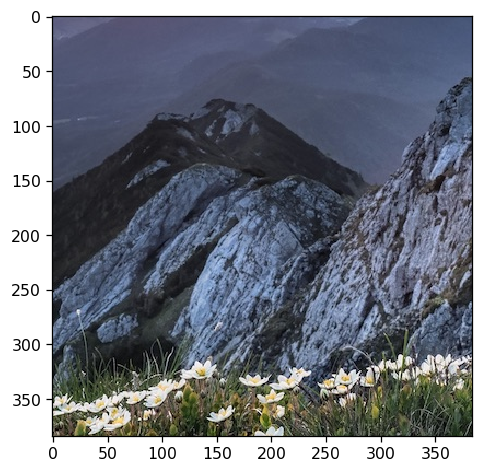

In [66]:
#tensor_image = io.read_image("/home/superres/workspace/superresolution/zurich-raw-to-rgb/canon/175.jpg")/255 # Channel x Height x Wîdth
#tensor_image = (io.read_image("/home/superres/workspace/superresolution/zurich-raw-to-rgb/canon/3018.jpg")/255) # Channel x Height x Wîdth
#tensor_image = (io.read_image("/home/superres/workspace/superresolution/zurich-raw-to-rgb/canon/328.jpg")/255)[:,200:400,200:400] # Channel x Height x Wîdth
#tensor_image = (io.read_image("/home/superres/workspace/superresolution/zurich-raw-to-rgb/canon/72.jpg")/255)[:,0:384, 0:384] # Channel x Height x Wîdth
tensor_image = (io.read_image("/home/superres/rawliif/report/hr_mountain_crop_for_raw.jpg")/255)[:,0:384, 0:384] # Channel x Height x Wîdth

print(tensor_image.size())
plot_tensor(tensor_image)

In [118]:
from math import ceil
def resize_fn(img, mag_factor): #resizes to target size and transforms entries from RGB (0 - 255) to [0,1]
        return transforms.ToTensor()(
        transforms.Resize((ceil(img.shape[1]/mag_factor), ceil(img.shape[2]/mag_factor)), Image.BICUBIC)(
            transforms.ToPILImage()(img))) #HxWxC, same as torch.read_image

Generate noisy raw input and plot linear space image

In [139]:
mag_factor = 2.2
burst_size = 4

tensor_input = resize_fn(tensor_image, mag_factor)[:,:-1,:-1]
print(tensor_input.shape)

importlib.reload(rgb2raw)
#Generate noisy raw input and plot linear space image
rgb2raw_image_burst, hr_lin, rgb2raw_image_burst_rgb, flow_vectors, hr_meta_info = rgb2raw.rgb2rawburst(
        tensor_image, tensor_input.shape[1], burst_size = burst_size, downsample_factor=tensor_image.shape[1]/tensor_input.shape[1], burst_transformation_params={'max_translation': 5.0,  'max_rotation': 1.0,  'max_shear': 0.0,  'max_scale': 0.0,  'border_crop': 5},
        #image_processing_params={'random_ccm': hr_meta_info["rgb2cam"], 'random_gains': [hr_meta_info["rgb_gain"], hr_meta_info["red_gain"],hr_meta_info["blue_gain"]], 'smoothstep': True, 'gamma': True, 'add_noise': True})
        image_processing_params={'random_ccm': True, 'random_gains': True, 'smoothstep': True, 'gamma': True, 'add_noise': True})
#rgb2raw_image_noisy = rgb2raw_image_burst.squeeze()
plt.figure()
plot_tensor(hr_lin)
print(rgb2raw_image_burst_rgb.size())
plt.figure()
plot_burst_tensor(rgb2raw_image_burst_rgb)
print(rgb2raw_image_burst.shape)
print(hr_lin.shape)

torch.Size([3, 174, 174])
torch.Size([4, 3, 174, 174])
torch.Size([4, 4, 87, 87])
torch.Size([3, 384, 384])


/tmp/ipykernel_1749317/3329633592.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((ceil(img.shape[1]/mag_factor), ceil(img.shape[2]/mag_factor)), Image.BICUBIC)(
/home/superres/.local/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Generate Burst Architecture Prediction

In [142]:
import os
import torch
from torchvision import transforms

import models as models
from utils import make_coord
import test
from test import batched_predict
import yaml

magnification_factor = mag_factor
importlib.reload(test)
#here once can choose the architecture that should be used for 

#with open("/home/superres/workspace/superresolution/rawliif/liif_for_raw/save/experiment_17_burstrdn/config_debug.yaml", 'r') as f:
#with open("/home/superres/workspace/superresolution/rawliif/liif_for_raw/save/experiment_18_burstanetrdn/config_debug.yaml", 'r') as f:
#with open("/home/superres/workspace/superresolution/rawliif/liif_for_raw/save/experiment_20_burstrdnanet_resume_exp_19/config_debug.yaml", 'r') as f:
with open("/home/superres/workspace/superresolution/rawliif/liif_for_raw/save/experiment_19_burstrdnanet/config_debug.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

def visual_val(raw_input, config, magnification_factor = 1, gpu=0):
    raw_input = (raw_input - config["data_norm"]["inp"]["sub"][0])/config["data_norm"]["inp"]["div"][0]
    os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    model = models.make(config["model"], load_sd=True).cuda()
    resolution = tuple([magnification_factor*i*2 for i in raw_input.size()[3:]])
    h, w = resolution
    h, w = list(map(int, resolution))
    print("h,w", h,w)
    coord = make_coord((h, w)).cuda()
    print("coord shape: ", coord.shape)
    cell = torch.ones_like(coord)
    print("coord shape: ", coord.shape)
    cell[:, 0] *= 2 / h
    cell[:, 1] *= 2 / w
    pred = batched_predict(model, raw_input.cuda(), coord.unsqueeze(0), cell.unsqueeze(0), bsize=30000)[0]
    pred = (pred * 0.5 + 0.5).clamp(0, 1).view(h, w, 3).permute(2, 0, 1)
    return pred
print(rgb2raw_image_burst.shape)
pred_burst = visual_val(rgb2raw_image_burst.unsqueeze(0), config, magnification_factor, gpu=3).cpu()
print(pred_burst.shape)

torch.Size([4, 4, 87, 87])
self.encoder.out_dim:  256
h,w 382 382
coord shape:  torch.Size([145924, 2])
coord shape:  torch.Size([145924, 2])
inp shape  torch.Size([1, 4, 4, 87, 87])
deep feature burst shape: torch.Size([1, 4, 64, 87, 87])
shape of input to anet:  torch.Size([1, 128, 87, 87])
0 th layer: shape after layer:  torch.Size([1, 128, 87, 87])
1 th layer: shape after layer:  torch.Size([1, 128, 87, 87])
2 th layer: shape after layer:  torch.Size([1, 128, 87, 87])
3 th layer: shape after layer:  torch.Size([1, 128, 87, 87])
4 th layer: shape after layer:  torch.Size([1, 128, 87, 87])
5 th layer: shape after layer:  torch.Size([1, 384, 87, 87])
6 th layer: shape after layer:  torch.Size([1, 384, 87, 87])
aligned concatenated deep feature burst shape: torch.Size([1, 256, 87, 87])
model.feat.shape  torch.Size([1, 256, 87, 87])
torch.Size([3, 382, 382])


Generate Single-Image-Architecture

In [126]:
import os
import torch
from torchvision import transforms

import models as models
from utils import make_coord
from test import batched_predict
import yaml

magnification_factor = mag_factor

#with open("/home/superres/workspace/superresolution/rawliif/liif_for_raw/save/experiment_12_res_replic_encoder/config_debug.yaml", 'r') as f:
with open("/home/superres/workspace/superresolution/rawliif/liif_for_raw/save/experiment_11_rdnencoder/config_debug.yaml", 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

def visual_val(raw_input, config, magnification_factor = 1, gpu=0):
    raw_input = (raw_input - config["data_norm"]["inp"]["sub"][0])/config["data_norm"]["inp"]["div"][0]
    os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    model = models.make(config["model"], load_sd=True).cuda()
    resolution = tuple([magnification_factor*i*2 for i in raw_input.size()[1:]])
    h, w = resolution
    h, w = list(map(int, resolution))
    coord = make_coord((h, w)).cuda()
    cell = torch.ones_like(coord)
    cell[:, 0] *= 2 / h
    cell[:, 1] *= 2 / w
    pred = batched_predict(model, raw_input.cuda().unsqueeze(0), coord.unsqueeze(0), cell.unsqueeze(0), bsize=30000)[0]
    pred = (pred * 0.5 + 0.5).clamp(0, 1).view(h, w, 3).permute(2, 0, 1)
    return pred
pred_single = visual_val(rgb2raw_image_burst[0], config, magnification_factor, gpu=3).cpu()
print("single: ", rgb2raw_image_burst[0].shape)
print(pred_single.shape)

self.encoder.out_dim:  64
inp shape  torch.Size([1, 4, 24, 24])
model.feat.shape  torch.Size([1, 64, 24, 24])
single:  torch.Size([4, 24, 24])
torch.Size([3, 384, 384])


In [116]:
import numpy as np
upscaled_input_test = np.repeat(rgb2raw_image_burst_rgb[0], magnification_factor, axis=1)
upscaled_input_test = torch.Tensor(np.repeat(upscaled_input_test, magnification_factor, axis=2))
upscaled_input_test.shape

torch.Size([3, 344, 344])

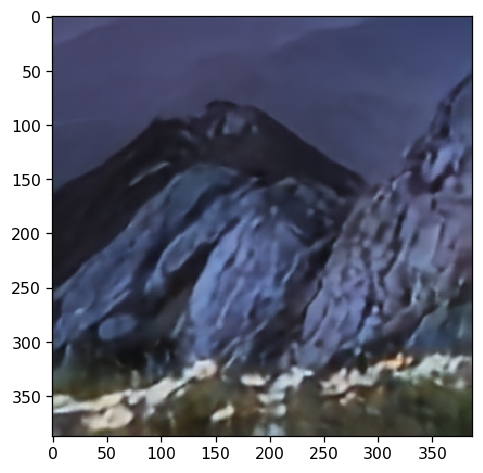

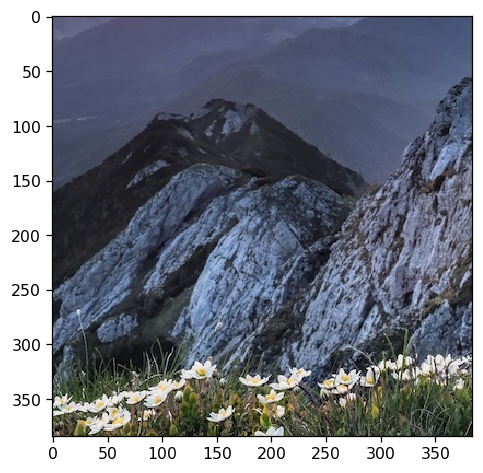

In [127]:
def lin2rgb(raw_img):
    raw_img = rgb2raw.apply_gains(raw_img, hr_meta_info["rgb_gain"], hr_meta_info["red_gain"], hr_meta_info["blue_gain"])
    raw_img = rgb2raw.apply_ccm(raw_img, hr_meta_info["cam2rgb"])
    raw_img = rgb2raw.gamma_compression(raw_img)
    rgb_img = rgb2raw.apply_smoothstep(raw_img)
    return rgb_img
plot_tensor(lin2rgb(pred_single.cpu()))
plt.figure()
plot_tensor(lin2rgb(pred_burst.cpu()))
plt.figure()
plot_tensor(lin2rgb(hr_lin))
#describe_tensor(pred.cpu())
#plot_tensor(lin2rgb(upscaled_input_test), lin2rgb(pred.cpu()))

Calculate PSNR

In [1]:
def calc_psnr(sr, hr, dataset=None, scale=1, rgb_range=1):
    #print("calc_psnr: \n", "max value sr: ", torch.max(sr), "min value sr: ", torch.min(sr), "max value hr: ", torch.max(hr), "min value hr: ", torch.min(hr))
    #print("sr_dim: ", sr.size)
    #print("hr: ", hr.size)
    diff = (sr - hr) / rgb_range
    if dataset is not None:
        if dataset == 'benchmark':
            shave = scale
            if diff.size(1) > 1:
                gray_coeffs = [65.738, 129.057, 25.064]
                convert = diff.new_tensor(gray_coeffs).view(1, 3, 1, 1) / 256 #why 256?
                diff = diff.mul(convert).sum(dim=1)
        elif dataset == 'div2k':
            shave = scale + 6
        else:
            raise NotImplementedError
        valid = diff[..., shave:-shave, shave:-shave]
    else:
        valid = diff
    mse = valid.pow(2).sum()/(3*valid.shape[1]*valid.shape[2])
    return -10 * torch.log10(mse)
print("psnr of prediction:", calc_psnr(lin2rgb(pred_single), lin2rgb(hr_lin)))
print("psnr of burst:", calc_psnr(lin2rgb(pred_burst), lin2rgb(hr_lin)))

NameError: name 'lin2rgb' is not defined